In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F

import cv2
import random
import matplotlib.pyplot as plt
import _init_paths
from tracker.multitracker_jersey import JDETracker
from opts import opts
import datasets.dataset.jde as datasets
from models.decode import mot_decode
from models.utils import _tranpose_and_gather_feat

from datasets.dataset_factory import get_dataset
from torchvision.transforms import transforms as T
import json

In [21]:
class Recheck(nn.Module):
    
    def __init__(self, inp=1, oup=1, stride=1, expand_ratio=256):  
        super(Recheck, self).__init__()
        
        hidden_dim = 256
        inp = 1
        oup = 1
        self.inverted_bottleneck = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup)
            )
        
        hidden_dim = 256
        inp = 64
        oup = 1
        self.last_block = nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 3, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.Sigmoid()
            )
    

    def forward(self, x, origFeat):
        
        invOut = x + self.inverted_bottleneck(x)
        origEnhanced = invOut * origFeat
        return self.last_block(origEnhanced)
        
    
    def process_raw_inp(self, raw, proc):
        
        ### Process previous and current features
        corrFilters = self.correlation(raw, proc)
        sumFilters = self.get_sum_of_filters(corrFilters, radius=2)
        
        return sumFilters.detach()
        
    def get_mask(self, corr_filter, radius=4):

        list_inds = []
        max_ind = (corr_filter==torch.max(corr_filter)).nonzero()[0].tolist()
        for i in range(max_ind[0]-radius, max_ind[0]+radius):
            for j in range(max_ind[1]-radius, max_ind[1]+radius):
                list_inds.append([i, j])

        mask = torch.zeros(corr_filter.shape).cuda()
        for idx in list_inds:
            mask[idx[0], idx[1]] = 1

        return mask
    
    def correlation(self, x, kernel):
        '''
        feats = (batch_size, emb_size, H, W)
        kernel = (batch_size, N, emb_size)

        output = (batch_size, N, H, W)
        '''
        kernel = kernel.view(kernel.size()[0], kernel.size()[1]*kernel.size()[2])
        kernel = kernel.unsqueeze(-1).unsqueeze(-1)

        batch = x.size()[0]

        pk = kernel.view(-1, x.size()[1], kernel.size()[2], kernel.size()[3])
        px = x.view(1, -1, x.size()[2], x.size()[3])
        po = F.conv2d(px, pk, groups=batch)
        po = po.view(batch, -1, po.size()[2], po.size()[3])

        return po
    
    def get_sum_of_filters(self, corr_filters, radius=3):
    
        results = []

        for batch in corr_filters:

            final_filt = torch.zeros(batch[0].shape).cuda()
            for filt in corr_filters[0]:
                mask = self.get_mask(filt, radius)
                new_filter = mask*filt

                final_filt += new_filter

            results.append(final_filt.unsqueeze(0))


        return torch.stack(results)

In [22]:
model = Recheck().cuda()

In [5]:
opt = opts().init(jupyter=True)
opt.arch = 'dlarecheck_34'
opt.load_model = '../exp/mot/custom_5vals_colors_all_30ep_data2_50ep/model_30.pth'
tracker = JDETracker(opt)

Fix size testing.
training chunk_sizes: [4]
The output will be saved to  /home/ubuntu/oljike/PlayerTracking/FairMOT/src/lib/../../exp/mot/default
heads {'hm': 1, 'wh': 4, 'id': 128, 'reg': 2}
Creating model...
loaded ../exp/mot/custom_5vals_colors_all_30ep_data2_50ep/model_30.pth, epoch 30


In [6]:
Dataset = get_dataset(opt.dataset, opt.task)
f = open('./lib/cfg/custom.json')
data_config = json.load(f)
trainset_paths = data_config['train']
valset_paths = data_config['test']
dataset_root = data_config['root']
transforms = T.Compose([T.ToTensor()])
cust_aug = True
dataset = Dataset(opt, dataset_root, trainset_paths, (1088, 608), augment=False, transforms=transforms)
train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=opt.num_workers,
        pin_memory=True,
        drop_last=True
    )

dataset summary
OrderedDict([('custom', 146556.0)])
total # identities: 146557
start index
OrderedDict([('custom', 0)])


In [7]:
raw, proc = [], []
for i, batch in enumerate(train_loader):
    
    im_blob = batch['input'].cuda()
    with torch.no_grad():
        output, orig_feat = tracker.model(im_blob)#[-1]
        output = output[-1]
        hm = output['hm'].sigmoid_()
        wh = output['wh']
        id_feature = output['id']
        id_feature = F.normalize(id_feature, dim=1)
        raw.append(id_feature)
        
        reg = output['reg'] if opt.reg_offset else None
        dets, inds = mot_decode(hm, wh, reg=reg, ltrb=opt.ltrb, K=10)
        proc_id_feature = _tranpose_and_gather_feat(id_feature, inds)
        proc.append(proc_id_feature)
    
    print(id_feature.shape, proc_id_feature.shape)    
    if i==1: break

torch.Size([1, 128, 152, 272]) torch.Size([1, 10, 128])
torch.Size([1, 128, 152, 272]) torch.Size([1, 10, 128])


Output of fairmot 


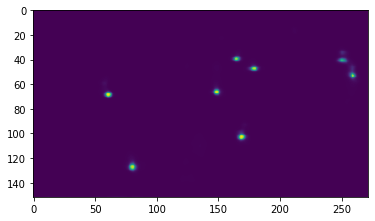

In [8]:
print('Output of fairmot ')
plt.imshow(hm[0][0].cpu().numpy())

Ground truth output 


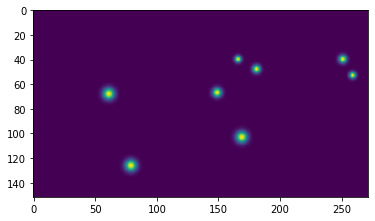

In [9]:
print('Ground truth output ')
plt.imshow(batch['hm'][0][0].cpu().numpy())

In [23]:
procInp = model.process_raw_inp(raw[-1], proc[0])
output = model(procInp, orig_feat)

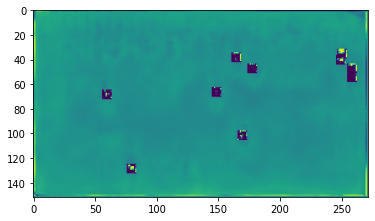

In [24]:
plt.imshow(output[0][0].cpu().detach().numpy())

### Compute loss

In [28]:
def logisticMSE(pred, target):
    '''
    pred = (batch, 1, H, W)
    target = (batch, 1, H, W)
    '''

    loss = torch.mean(- target * (1 - pred) * torch.log(pred+1e-15) - (1 - target) * pred * torch.log(1 - pred+1e-15))
    
    loss_stats = {'loss': loss}
    
    return loss, loss_stats 

In [29]:
loss, loss_stats = logisticMSE(output, batch['hm'].cuda())
print('Loss is ', loss)

Loss is  tensor(0.42543, device='cuda:0', grad_fn=<MeanBackward0>)


In [30]:
loss.backward()

RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling backward the first time.

# Trash

### Correlation function

In [13]:
def correlation(x, kernel):
    '''
    feats = (batch_size, emb_size, H, W)
    kernel = (batch_size, N, emb_size)
    
    output = (batch_size, N, H, W)
    '''
    kernel = kernel.view(kernel.size()[0], kernel.size()[1]*kernel.size()[2])
    kernel = kernel.unsqueeze(-1).unsqueeze(-1)

    batch = x.size()[0]
    
    pk = kernel.view(-1, x.size()[1], kernel.size()[2], kernel.size()[3])
    px = x.view(1, -1, x.size()[2], x.size()[3])
    po = F.conv2d(px, pk, groups=batch)
    po = po.view(batch, -1, po.size()[2], po.size()[3])

    return po

In [14]:
corr_filters = correlation(raw[-1], proc[0])

In [15]:
idx = 0

0


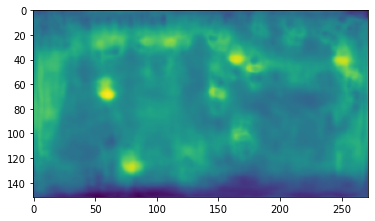

In [16]:
# idx = random.choice(range(len(corr_filters[0])))
print(idx)
rand_filt = corr_filters[0][idx]
plt.imshow(rand_filt.cpu().numpy())
idx += 1

/home/ubuntu/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  


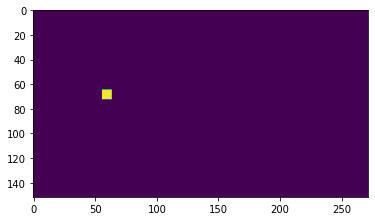

In [17]:
def get_mask(corr_filter, radius=4):
    ''''''
    
    
    list_inds = []
    max_ind = (corr_filter==torch.max(corr_filter)).nonzero()[0].tolist()
    for i in range(max_ind[0]-radius, max_ind[0]+radius):
        for j in range(max_ind[1]-radius, max_ind[1]+radius):
            list_inds.append([i, j])
    
    mask = torch.zeros(corr_filter.shape).cuda()
    for idx in list_inds:
        mask[idx[0], idx[1]] = 1
        
    return mask

mask = get_mask(rand_filt, radius=4)
plt.imshow(mask.cpu().numpy())

torch.Size([1, 1, 152, 272])


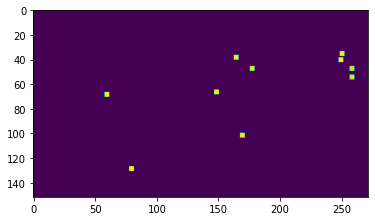

In [18]:
def get_sum_of_filters(corr_filters, radius=3):
    
    results = []
    
    for batch in corr_filters:
        
        final_filt = torch.zeros(batch[0].shape).cuda()
        for filt in corr_filters[0]:
            mask = get_mask(filt, radius)
            new_filter = mask*filt

            final_filt += new_filter
    
        results.append(final_filt.unsqueeze(0))
        
        
    return torch.stack(results)


corr_filters = correlation(raw[-1], proc[0])
final_filt = get_sum_of_filters(corr_filters, radius=2)
print(final_filt.shape)
plt.imshow(final_filt[0][0].cpu().numpy())

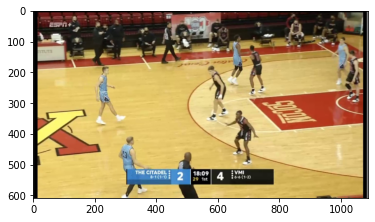

In [19]:
plt.imshow(batch['input'][0].cpu().permute(1,2,0).numpy())

### Inverted Bottleneck

In [20]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]
        
        '''
        output = (batch, H, W, 1)
        '''

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup

        self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [21]:
invBlock = InvertedResidual(inp=1, oup=1, stride=1, expand_ratio=256).cuda()

In [22]:
invOut = invBlock(final_filt)
invOut.shape

torch.Size([1, 1, 152, 272])

In [23]:
origFeat = orig_feat#torch.rand(1,64, 152,272).cuda()

In [24]:
origEnhanced = invOut*origFeat
origEnhanced.shape

torch.Size([1, 64, 152, 272])

In [44]:
class LastBlock(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(LastBlock, self).__init__()
        
        hidden_dim = 256
        self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 3, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, oup, 1, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
#                 nn.ReLU(inplace=True),
                nn.Sigmoid()
            )

    def forward(self, x):
        return self.conv(x)
    
lastBlock = LastBlock(inp=64, oup=1, stride=1, expand_ratio=256).cuda()

In [45]:
origFinal = lastBlock(origEnhanced)

In [46]:
origFinal

tensor([[[[0.42732, 0.42732, 0.42732,  ..., 0.42732, 0.42732, 0.42732],
          [0.42732, 0.99667, 0.99846,  ..., 0.98216, 0.85345, 0.42732],
          [0.42732, 0.95909, 0.45460,  ..., 0.41060, 0.99956, 0.42732],
          ...,
          [0.42732, 0.92353, 0.45732,  ..., 0.47642, 0.99764, 0.42732],
          [0.42732, 0.99909, 0.99737,  ..., 0.99916, 0.99999, 0.42732],
          [0.42732, 0.42732, 0.42732,  ..., 0.42732, 0.42732, 0.42732]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

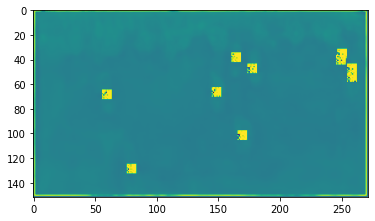

In [47]:
plt.imshow(origFinal[0][0].cpu().detach().numpy())

### Implement Loss function and fusion algorithm.

In [52]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

def logisticMSE(pred, target):
    '''
    pred = (batch, 1, H, W)
    target = (batch, 1, H, W)
    '''
    loss = torch.mean(- target * (1 - pred) * torch.log(pred+1e-15) - (1 - target) * pred * torch.log(1 - pred+1e-15))
    
    return loss

logisticMSE(origFinal, batch['hm'].cuda())

tensor(0.38929, device='cuda:0', grad_fn=<MeanBackward0>)

In [51]:
batch['hm'].max(), batch['hm'].min()

(tensor(1.), tensor(0.))

In [53]:
### Create dataloader and check the probability maps and create mask from them.